In [1]:
using Plots, DelimitedFiles, Statistics
pyplot()
using Revise, MDToolbox
import Logging
@info "max threads:$(Threads.nthreads())"

[ Info: max threads:4


# Setup data

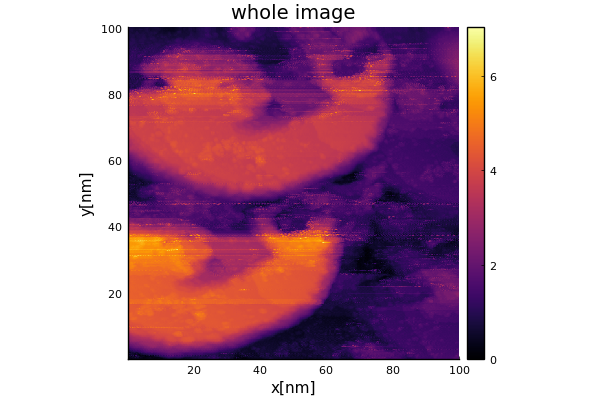

In [2]:
# 画像の読み込み
image_filename = "B3439.tsv"

whole_image_size_px = 512
whole_image_size_aa = 1000.0
resolution = whole_image_size_aa / whole_image_size_px # 1000\AA/ 512px
whole_image = readdlm(image_filename, '\t', Float64; skipstart=4) .* 1.0e10

heatmap(
    collect(1:512) .* resolution / 10, collect(1:512) .* resolution / 10, whole_image ./ 10,
    xlabel="x[nm]", ylabel="y[nm]", title="whole image", aspect_ratio=:equal
)

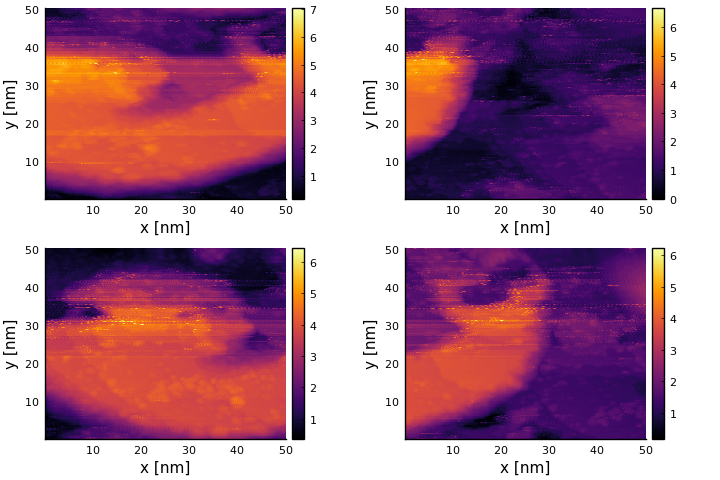

In [3]:
# 画像を分割して抽出
separated_images::Vector{Matrix{Float64}} = []
image_size = 256
for ix=0:1, iy=0:1
    push!(
        separated_images,
        whole_image[image_size*ix+1:image_size*(ix+1), image_size*iy+1:image_size*(iy+1)]
    )
end

plots = []
grid = collect(1:image_size) .* resolution / 10
for i in [1, 2, 3, 4]
    push!(
        plots,
        heatmap(grid, grid, separated_images[i]./10, xlabel="x [nm]", ylabel="y [nm]", aspext_ratio=:equal)
    )
end
plot(plots..., layout=(2,2), size=(720, 480))

# Original BTR reconstruction

In [4]:
T = [4.0, 8.0, 10.0, 20.0] # thresholdに使う値[\AA]

loss_over_t = Vector{Float64}(undef, length(T))
P_over_t = Vector{Matrix}(undef, length(T))
tip_size = 32
tip_grid = collect(1:tip_size) .* resolution / 10.0

Threads.@threads for it in 1:length(T)
    @info "thread id:$(Threads.threadid()), it:$(it), t:$(T[it])"
    m_P = zeros(Float64, tip_size, tip_size) # `削り出し`前の探針形状(平坦)の配列を作る

    itip_estimate!(m_P, separated_images, thresh=T[it]) # 探針形状と試料形状を推定する

    loss = 0.0
    for image in separated_images
        loss += mean((idilation(ierosion(image, m_P), m_P) .- image).^2)
    end
    loss = loss / length(separated_images)

    P_over_t[it] = m_P
    loss_over_t[it] = loss
end

[ Info: thread id:1, it:1, t:4.0
[ Info: thread id:4, it:2, t:8.0
[ Info: thread id:3, it:3, t:10.0
[ Info: thread id:2, it:4, t:20.0


Processed 4 image
285 refinements 
Processed 4 image
375 refinements 
Processed 4 image
69 refinements 
Processed 4 image
640 refinements 


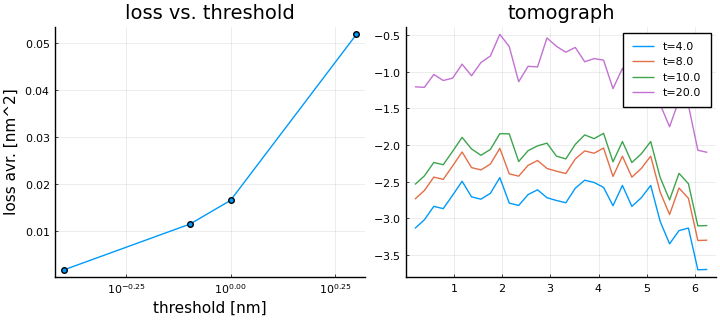

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [5]:
tvsl = plot(
    T./10.0, loss_over_t./100.0,
    xaxis=:log, markershape=:circle,
    label=nothing,
    xlabel="threshold [nm]", ylabel="loss avr. [nm^2]", title="loss vs. threshold"
)


tmg = plot()
y_slice = round(Integer, tip_size / 2) + 1
for it = 1:length(T)
    plot!(tmg, tip_grid, P_over_t[it][y_slice,:] ./ 10.0, label="t=$(T[it])")
end
title!(tmg, "tomograph")
p = plot(tvsl, tmg, layout=(1,2), size=(720, 320))

In [6]:
its = 1:4
plt_layout = (2,2)

(2, 2)

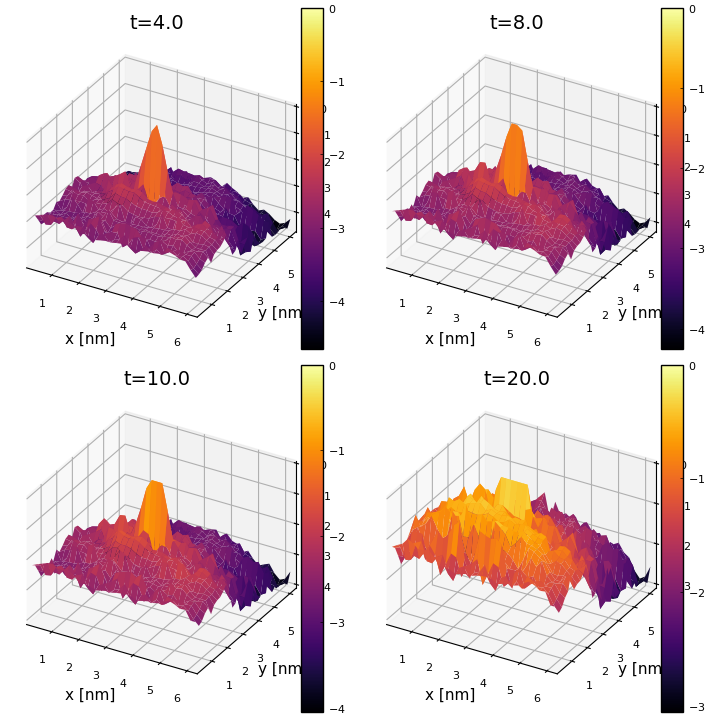

In [7]:
plots = Vector{Any}(undef, length(its))
    
for it in its
    plots[it] = plot(
        tip_grid, tip_grid, P_over_t[it] ./ 10.0, st=:surface,
        xlabel="x [nm]", ylabel="y [nm]", title="t=$(T[it])"
    )
end

p = plot(plots..., layout=plt_layout, size=(720, 720))

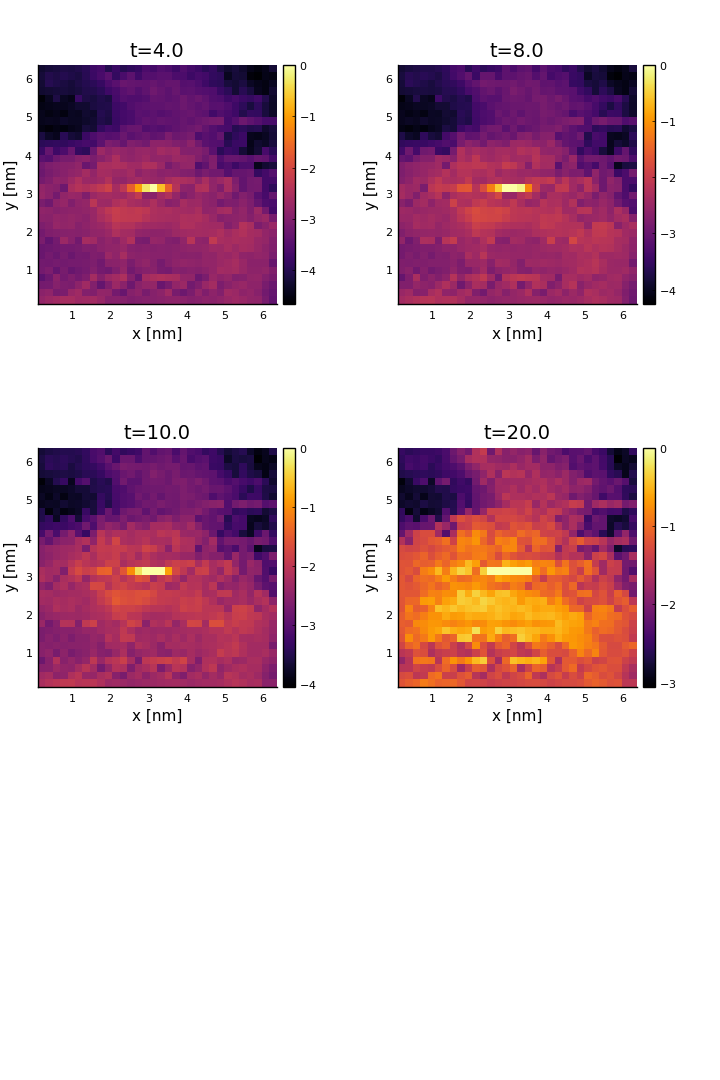

In [8]:
plots = Vector{Any}(undef, length(its))
    
for it in its
    plots[it] = heatmap(
        tip_grid, tip_grid, P_over_t[it] ./ 10.0, aspect_ratio=:equal,
        xlabel="x [nm]", ylabel="y [nm]", title="t=$(T[it])"
    )
end

p = plot(plots..., layout=(3,2), size=(720, 1080))

# differentiable BTR reconstruction

In [9]:
using Flux
using Flux.Data: DataLoader

In [10]:
struct DifferentiableBTRResult
    lambdas::Vector{Float64}
    max_epoch::Integer
    loss_over_lambdas::Vector{Float64}
    loss_history_over_lambdas::Vector{Vector{Float64}}
    loss_minimizinf_P_over_lambdas::Vector{Matrix}
    final_P_over_lambdas::Vector{Matrix}
end

struct Tip
    P::AbstractArray
end
Tip(size::Integer) = Tip(zeros(Float64, size, size))
Flux.@functor Tip (P,)
(m::Tip)(image) = idilation(ierosion(image, m.P), m.P)

function solve(
        images::Vector{Matrix{Float64}}, tip_size::Integer;
        max_epoch::Integer=512, lambdas::Vector{Float64}=[1e-5, 1e-4, 1e-3, 1e-2]
    )
    images_copy = deepcopy(images)
    loss_over_lambdas = Vector{Float64}(undef, length(lambdas))
    loss_history_over_lambdas = Vector{Vector{Float64}}(undef, length(lambdas))
    final_P_over_lambdas = Vector{Matrix}(undef, length(lambdas))
    loss_minimizing_P_over_lambdas = Vector{Matrix}(undef, length(lambdas))

    @time Threads.@threads for it in 1:length(lambdas)
        lambda = lambdas[it]
        @info "thread id: $(Threads.threadid()), lambda:$(lambda)"

        m = Tip(tip_size)

        #  各画像対の二乗平均誤差:mean((image_randn_copy .- image_randn)^2)を求めて全画像の平均を取る
        loss(x, y) = mean(Flux.Losses.mse.(m.(x),y))

        ps = Flux.params(m)

        train_loader = Flux.Data.DataLoader(
            (data=images_copy, label=images), batchsize=1, shuffle=false
        );

        opt = ADAMW(1.0, (0.9, 0.999), lambda)

        loss_train = Vector{Float64}(undef, max_epoch)
        loss_minimizing_P_over_lambdas[it] = deepcopy(m.P)

        for epoch in 1:max_epoch
            for (x, y) in train_loader
                gs = gradient(() -> loss(x, y), ps)
                Flux.Optimise.update!(opt, ps, gs)
                m.P .= min.(m.P, 0.0)
                m.P .= MDToolbox.translate_tip_mean(m.P)
            end
            tmp_loss = loss(images_copy, separated_images)
            if (tmp_loss < loss_train[end])
                loss_minimizing_P_over_lambdas[it] = deepcopy(m.P)
            end
            loss_train[epoch] = tmp_loss
        end

        loss_over_lambdas[it] = loss_train[end]
        loss_history_over_lambdas[it] = deepcopy(loss_train)
        final_P_over_lambdas[it] =  m.P
    end
    
    DifferentiableBTRResult(
        lambdas, max_epoch, loss_over_lambdas, loss_history_over_lambdas, loss_minimizing_P_over_lambdas, final_P_over_lambdas
    )
end

solve (generic function with 1 method)

In [31]:
results = []

Any[]

In [25]:
max_epoch = 128
lambdas = [1.0e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3, 1e-2, 1e-1]
tip_size = 48
tip_grid = collect(1:tip_size) .* resolution / 10.0
result = solve(separated_images, tip_size; max_epoch=max_epoch, lambdas=lambdas)

[ Info: thread id: 1, lambda:1.0e-8
[ Info: thread id: 4, lambda:0.01
[ Info: thread id: 3, lambda:1.0e-6
[ Info: thread id: 2, lambda:0.0001
[ Info: thread id: 4, lambda:1.0e-5
[ Info: thread id: 1, lambda:0.1
[ Info: thread id: 4, lambda:0.001
[ Info: thread id: 3, lambda:1.0e-7


1479.733485 seconds (1.67 M allocations: 44.769 GiB, 0.40% gc time)


DifferentiableBTRResult([1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 0.0001, 0.001, 0.01, 0.1], 128, [7.019867025892399, 6.7086801484920375, 6.843625127082473, 6.57079814955719, 7.5943081999462345, 7.684789942595023, 11.400638856533956, 18.948834880028322], [[21.963326734200457, 21.10450316237891, 20.30884885058125, 19.800204120958355, 19.30160300716775, 18.57350909041912, 18.006008615047048, 17.496157208407023, 16.802462193776677, 16.230381405894327  …  7.074788058680975, 7.062117517922035, 7.057281330122322, 7.076556963690785, 7.061249400590371, 7.050270211442041, 7.042079419588992, 7.0441669780532585, 7.035191676269813, 7.019867025892399], [21.96365797039944, 21.10382927027007, 20.302433139258277, 19.79150496635868, 19.227903345260017, 18.43733598994313, 17.852140056636788, 17.25967678488105, 16.6703183184178, 16.12296316248144  …  6.875089840670227, 6.832542471405743, 6.808802400092831, 6.800753217928729, 6.784172768057722, 6.7673829575506055, 6.731887952301804, 6.7214363684055956, 6.723928802

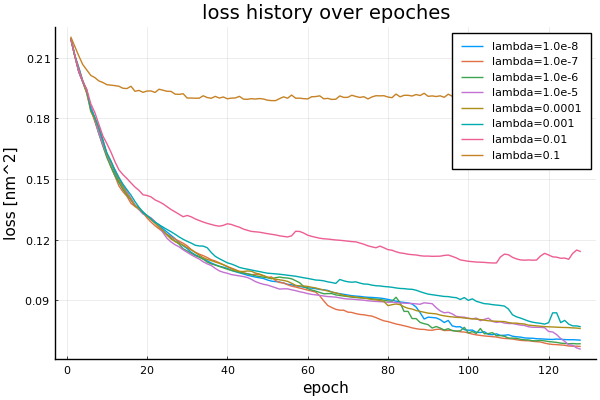

In [26]:
p = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history over epoches")
for it in 1:length(lambdas)
    plot!(p, collect(1:max_epoch), result.loss_history_over_lambdas[it] ./ 100, label="lambda=$(lambdas[it])")
end
p

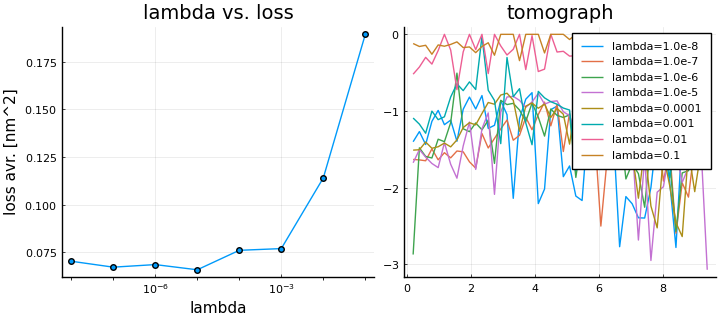

In [27]:
lvsl = plot(
    lambdas, result.loss_over_lambdas./100.0,
    xaxis=:log, markershape=:circle,
    label=nothing,
    xlabel="lambda", ylabel="loss avr. [nm^2]", title="lambda vs. loss"
)


y_slice = round(Integer, tip_size / 2) + 1
x_grid = collect(1:tip_size) .* resolution / 10.0

tmg = plot()
for it = 1:length(lambdas)
    plot!(tmg, x_grid, result.final_P_over_lambdas[it][y_slice,:] ./ 10.0, label="lambda=$(lambdas[it])")
end
title!(tmg, "tomograph")
p = plot(lvsl, tmg, layout=(1,2), size=(720, 320))

In [28]:
its = [4, 6, 7, 8]
plt_layout = (2,2)

(2, 2)

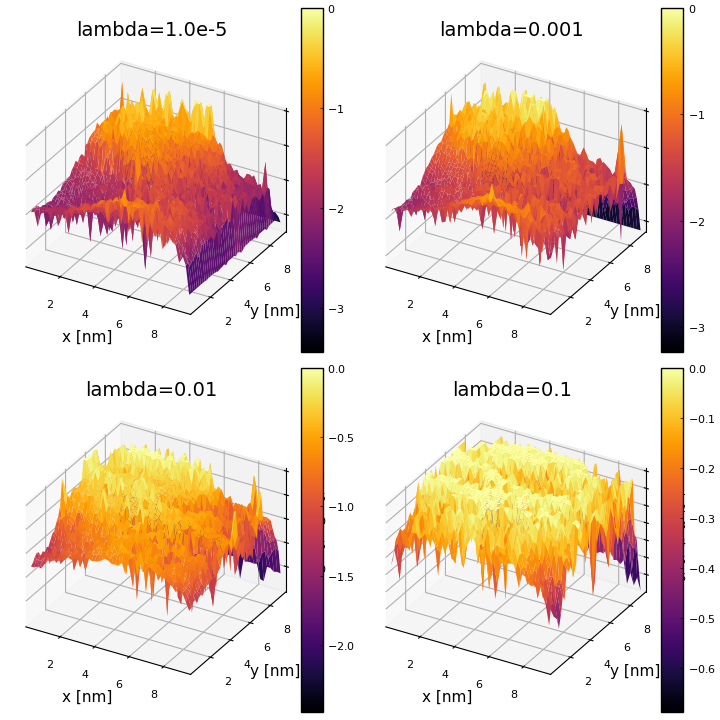

In [29]:
plots = Vector{Any}(undef, length(its))
    
for i in 1:length(its)
    it = its[i]
    plots[i] = plot(
        tip_grid, tip_grid, result.final_P_over_lambdas[it] ./ 10.0, st=:surface,
        xlabel="x [nm]", ylabel="y [nm]", title="lambda=$(lambdas[it])"
    )
end

p = plot(plots..., layout=plt_layout, size=(720, 720))

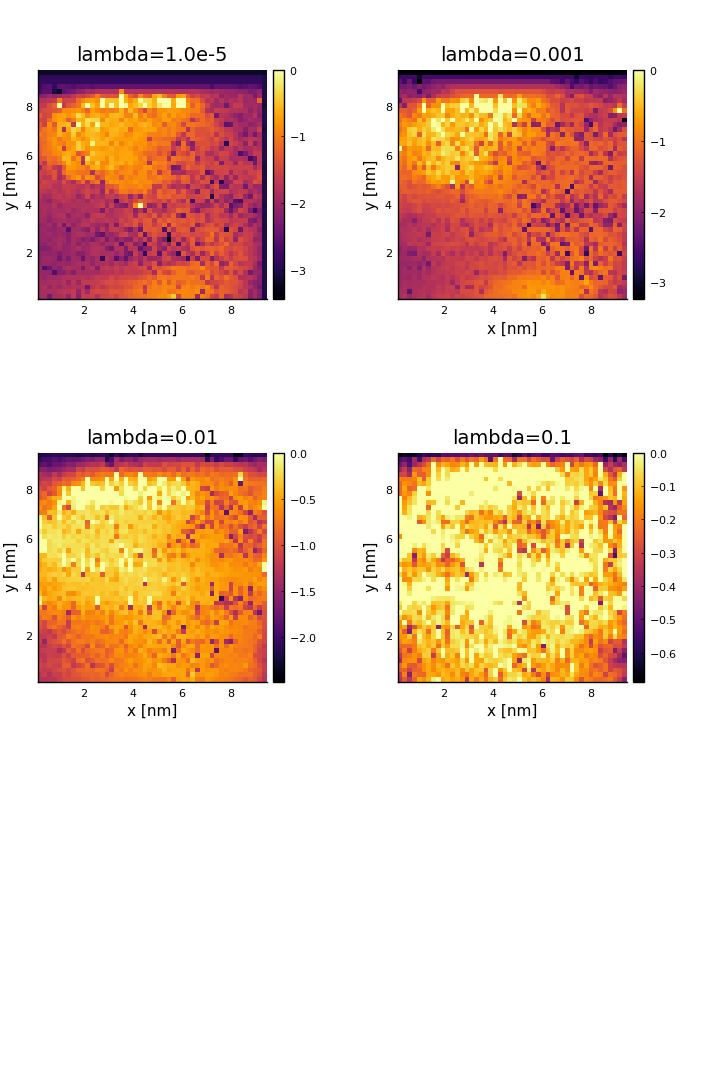

In [30]:
plots = Vector{Any}(undef, length(its))
    
for i = 1:length(its)
    it = its[i]
    plots[i] = heatmap(
        tip_grid, tip_grid, result.final_P_over_lambdas[it] ./ 10.0, aspect_ratio=:equal,
        xlabel="x [nm]", ylabel="y [nm]", title="lambda=$(lambdas[it])"
    )
end

p = plot(plots..., layout=(3,2), size=(720, 1080))

In [32]:
max_epoch = 512
lambdas = [1.0e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3, 1e-2, 1e-1]
tip_size = 64
tip_grid = collect(1:tip_size) .* resolution / 10.0
push!(results, solve(separated_images, tip_size; max_epoch=max_epoch, lambdas=lambdas))

[ Info: thread id: 1, lambda:1.0e-8
[ Info: thread id: 3, lambda:0.0001
[ Info: thread id: 2, lambda:1.0e-6
[ Info: thread id: 4, lambda:0.01
[ Info: thread id: 2, lambda:1.0e-7
[ Info: thread id: 3, lambda:1.0e-5
[ Info: thread id: 2, lambda:0.1
[ Info: thread id: 2, lambda:0.001


11000.961211 seconds (6.70 M allocations: 181.073 GiB, 0.42% gc time)


1-element Vector{Any}:
 DifferentiableBTRResult([1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 0.0001, 0.001, 0.01, 0.1], 512, [7.248189696761685, 7.837136598898029, 7.915241815232198, 6.888384906648982, 7.919511426316766, 7.774800652848316, 13.86745368834319, 27.088550560511532], [[30.06997407066133, 28.71844652822102, 27.940607907320704, 27.198068534506255, 26.31168359360507, 25.95855018266075, 25.423830578238494, 24.81257908406475, 23.994394868650364, 23.693803163599316  …  7.240756356573878, 7.244922401604881, 7.244629421670393, 7.254268972780961, 7.249720723455749, 7.241418464335625, 7.250068951994851, 7.250249285794165, 7.251801948141416, 7.248189696761685], [30.068545697358626, 28.72246198660676, 27.956307704053934, 27.250416427513215, 26.309851681827446, 25.988474090541875, 25.3664898504722, 24.61876409402643, 24.223534046738173, 23.626089061797003  …  7.841379927000377, 7.809675718482414, 7.81770362292344, 7.852978016693561, 7.804241394819574, 7.831004227800829, 7.851959557329628, 7.8140073

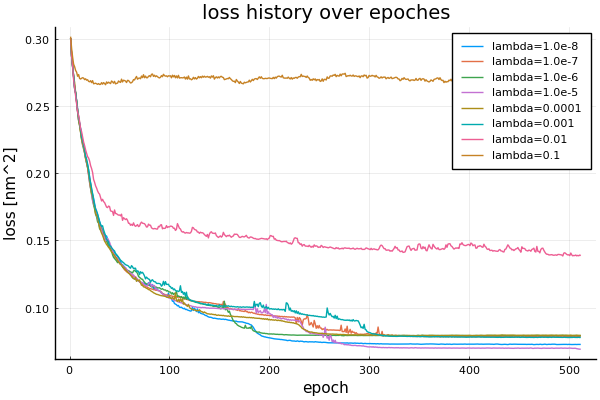

In [33]:
p = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history over epoches")
for it in 1:length(lambdas)
    plot!(p, collect(1:max_epoch), results[1].loss_history_over_lambdas[it] ./ 100, label="lambda=$(lambdas[it])")
end
p

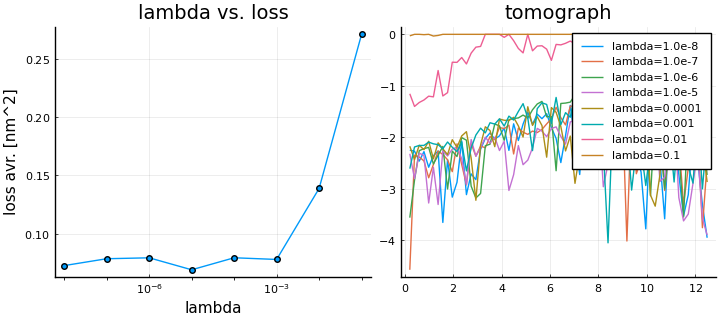

In [34]:
lvsl = plot(
    lambdas, results[1].loss_over_lambdas./100.0,
    xaxis=:log, markershape=:circle,
    label=nothing,
    xlabel="lambda", ylabel="loss avr. [nm^2]", title="lambda vs. loss"
)


y_slice = round(Integer, tip_size / 2) + 1
x_grid = collect(1:tip_size) .* resolution / 10.0

tmg = plot()
for it = 1:length(lambdas)
    plot!(tmg, x_grid, results[1].final_P_over_lambdas[it][y_slice,:] ./ 10.0, label="lambda=$(lambdas[it])")
end
title!(tmg, "tomograph")
p = plot(lvsl, tmg, layout=(1,2), size=(720, 320))

In [35]:
its = [5, 6, 7, 8]
plt_layout = (2,2)

(2, 2)

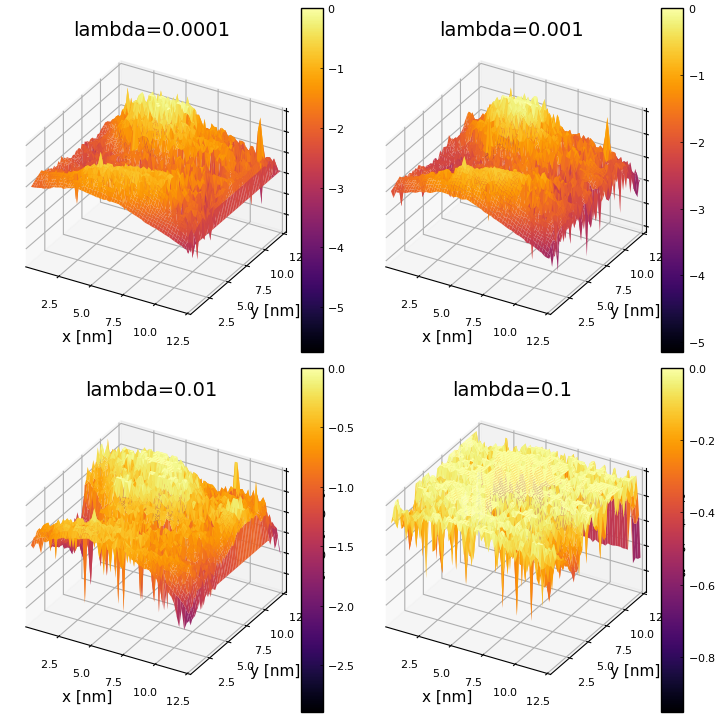

In [36]:
plots = Vector{Any}(undef, length(its))
    
for i in 1:length(its)
    it = its[i]
    plots[i] = plot(
        tip_grid, tip_grid, results[1].final_P_over_lambdas[it] ./ 10.0, st=:surface,
        xlabel="x [nm]", ylabel="y [nm]", title="lambda=$(lambdas[it])"
    )
end

p = plot(plots..., layout=plt_layout, size=(720, 720))

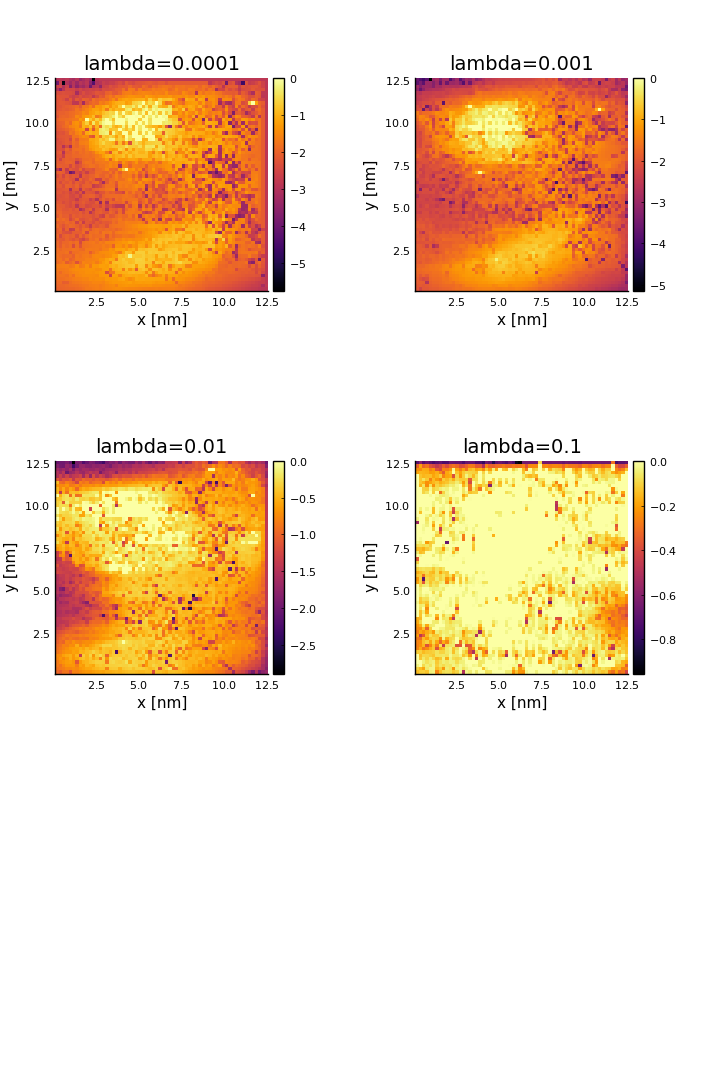

In [38]:
plots = Vector{Any}(undef, length(its))
    
for i = 1:length(its)
    it = its[i]
    plots[i] = heatmap(
        tip_grid, tip_grid, results[1].final_P_over_lambdas[it] ./ 10.0, aspect_ratio=:equal,
        xlabel="x [nm]", ylabel="y [nm]", title="lambda=$(lambdas[it])"
    )
end

p = plot(plots..., layout=(3,2), size=(720, 1080))

In [17]:
using BSON: @save, @load
@save "prepare_test_data.bson" width height resolution radius angle afmConfig models tip nx ny surfs images images_randn
mdsave("models.pdb", models)

LoadError: UndefVarError: width not defined